Epoch 1/300


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1707 - val_loss: 0.0339
Epoch 2/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1225 - val_loss: 0.0307
Epoch 3/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1142 - val_loss: 0.0239
Epoch 4/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0710 - val_loss: 0.0215
Epoch 5/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0834 - val_loss: 0.0272
Epoch 6/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0574 - val_loss: 0.0257
Epoch 7/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0707 - val_loss: 0.0165
Epoch 8/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0535 - val_loss: 0.0151
Epoch 9/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0384 - val_loss: 0.0137
Epoch 10/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0463 - val_loss: 0.0123
Epoch 11/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0375 - val_loss: 0.0128
Epoch 12/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0303 - val_lo

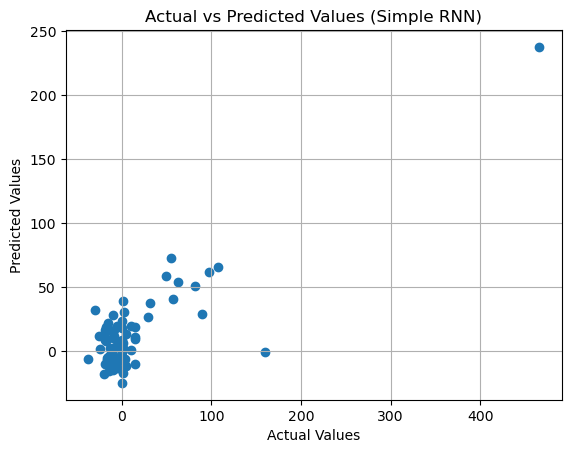

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Load the dataset
data = pd.read_csv('new_data2.csv')

# Drop the date column and set X, y
data = data.drop(columns=['date(dd/mm/yy)'])

# Creating lag features (shifted versions of the target 'HYB')
def create_lag_features(data, column, n_lags=3):
    for lag in range(1, n_lags + 1):
        data[f'{column}_lag{lag}'] = data[column].shift(lag)
    return data

# Adding lag features for 'HYB' (target column)
data_lagged = create_lag_features(data, 'HYB', n_lags=3)
data_lagged = data_lagged.dropna()  # Drop NaN values created by lagging

# Set X and y again after creating lag features
X = data_lagged.drop(columns=['HYB']).values
y = data_lagged['HYB'].values

# Scaling with MinMaxScaler
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Train-test split (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Reshape X for SimpleRNN (samples, timesteps, features)
X_train_rnn = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_rnn = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))


# Build a Simple RNN model
model_rnn = Sequential()
model_rnn.add(SimpleRNN(200, return_sequences=True, activation='tanh', input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])))
model_rnn.add(Dropout(0.3))
model_rnn.add(SimpleRNN(100, activation='tanh'))
model_rnn.add(Dropout(0.3))
model_rnn.add(Dense(1))  # Output layer for regression

# Compile the model with Adam optimizer and a custom learning rate
optimizer_rnn = Adam(learning_rate=0.0005)
model_rnn.compile(optimizer=optimizer_rnn, loss='mean_squared_error')

# Fit the model
history_rnn = model_rnn.fit(X_train_rnn, y_train, epochs=300, batch_size=16, validation_data=(X_test_rnn, y_test))

# Predictions on the test set
predictions_scaled_rnn = model_rnn.predict(X_test_rnn)
predictions_rnn = scaler_y.inverse_transform(predictions_scaled_rnn)  # Inverse transform predictions
y_test_rescaled_rnn = scaler_y.inverse_transform(y_test)  # Inverse transform y_test

# Custom MAPE to handle zeros
def custom_mape(y_true, y_pred):
    mask = y_true != 0  # Mask to filter out zero values in y_true
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# Calculating Metrics on test set
mse_rnn = mean_squared_error(y_test_rescaled_rnn, predictions_rnn)
rmse_rnn = np.sqrt(mse_rnn)
mape_rnn = custom_mape(y_test_rescaled_rnn, predictions_rnn)  # Use custom MAPE function
r2_rnn = r2_score(y_test_rescaled_rnn, predictions_rnn)

print(f'Mean Squared Error (MSE): {mse_rnn}')
print(f'Root Mean Squared Error (RMSE): {rmse_rnn}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_rnn}')
print(f'R-Squared (R²): {r2_rnn}')


# Export to Excel
output_df_rnn = pd.DataFrame({
    'Actual': y_test_rescaled_rnn.flatten(),
    'Predicted': predictions_rnn.flatten()
})
output_df_rnn.to_excel('actual_vs_predicted_rnn.xlsx', index=False)

# Scatter plot of actual vs predicted
plt.scatter(y_test_rescaled_rnn, predictions_rnn)
plt.title('Actual vs Predicted Values (Simple RNN)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()
